# Leave-K-Studies-Out Analysis
- This jupyter notebook is available on-line at:
  - https://github.com/spisakt/RPN-signature/blob/master/notebooks/4_leave-k-studies-out.ipynb
- Input data for the notebook and non-standard code (PAINTeR library) is available in the repo:
  - https://github.com/spisakt/RPN-signature
- Raw MRI-data from study-centers 1 and 2 are available on OpenNeuro:
  - https://openneuro.org/datasets/ds002608/versions/1.0.1
  - https://openneuro.org/datasets/ds002609/versions/1.0.3
- Raw data from center 3 is available upon reasonable request.

## Imports

In [1]:
import sys
sys.path.append('../')
from PAINTeR import connectivity # in-house lib used for the RPN-signature
from PAINTeR import plot # in-house lib used for the RPN-signature
from PAINTeR import model # in-house lib used for the RPN-signature
import numpy as np # hi old friend
import pandas as pd

from sklearn.preprocessing import StandardScaler
from nilearn.connectome import ConnectivityMeasure

from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")

from sklearn.linear_model import ElasticNet, Ridge
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import LeaveOneOut, KFold, GroupKFold, LeavePGroupsOut
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error, r2_score, explained_variance_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate

import scipy.stats as stats
import joblib

## Load and merge behavioral data for all three centers (after exclusions)

In [2]:
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study']='bochum'
df_essen['study']='essen'
df_szeged['study']='szeged'
df=pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df=df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


## Load preprocessed and scrubbed timeseries data

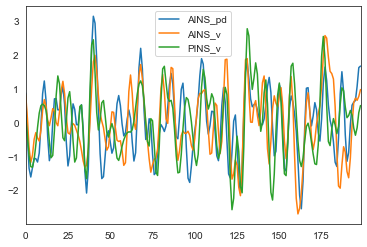

In [3]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'
    
    ts = pd.read_csv(f_scrub).iloc[:,1:] # here we can omit global signal...
    
    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd 
    
    perc_scrubbed.append(100 - 100*len(ts.shape)/len(fd) )
    timeseries.append(ts.values)
    
# double check visually
sub_idx=10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()

## Load region and module names for the MIST122 atlas

In [4]:
labels=ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules=np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

## Calculate functional connectivity as partial correlation

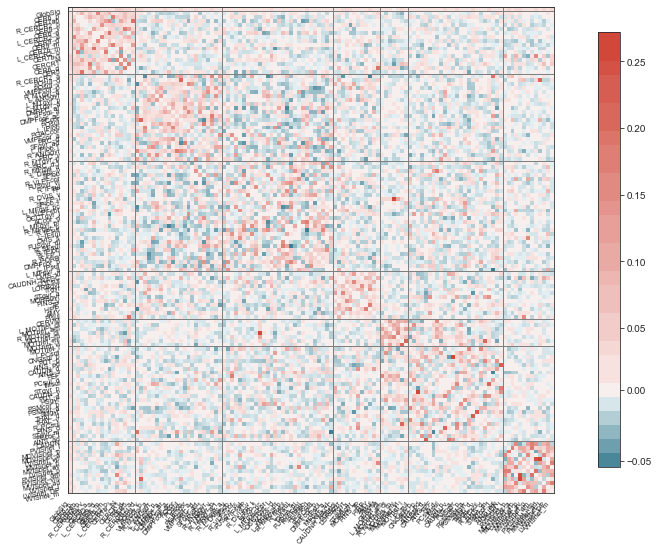

In [5]:
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=True, discard_diagonal=True)
X = correlation_measure.fit_transform(timeseries) # these are the features

# double-check the mean matrix visually
mat=correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0 # zero diag
plot.plot_matrix(mat, labels, modules)

## Pain sensitivity as target variable

In [6]:
y = df.mean_QST_pain_sensitivity

## Define model to be trained

In [7]:
# an oversimplified factory-function, defining the model to be trained:
def pipe_scale_fsel_elnet(scaler=preprocessing.RobustScaler(),
                          fsel=SelectKBest(f_regression),
                          model=ElasticNet(max_iter=100000),
                          p_grid={'fsel__k': [25, 50, 100, 1000, 3000],
                              'model__alpha': [.001, .005, .01, .05, .1, .5, 1, 5],
                              'model__l1_ratio': [0.0001, .25, .5, .75, 0.9999]         
                                   }):
                                      
    mymodel = Pipeline(
        [
         ('fsel', fsel),
         ('scaler', scaler),
         ('model', model)])
    return mymodel, p_grid

In [8]:
model, p_grid = pipe_scale_fsel_elnet()

## Nested leave-two-studies-out cross validation (L2SO)
I.e. training on one center only

In [9]:
outer_cv = LeavePGroupsOut(2) # LeaveTwoStudiesOut
inner_cv = LeaveOneOut() # LeaveOneOut, to maximize training samplke                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=df.study):                               
    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1


model	inner_cv mean score	outer vc score
Fitting 19 folds for each of 200 candidates, totalling 3800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 946 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 2367 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 2723 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 3173 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 3723 tasks      | elapsed: 10.6min
[Parallel(n_jobs=-1)]: Done 3800 out of 3800 | elapsed: 10.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


cv: 0 {'fsel__k': 25, 'model__alpha': 0.5, 'model__l1_ratio': 0.0001} -0.16005283477043922 -0.9152289478121729
Fitting 37 folds for each of 200 candidates, totalling 7400 fits


[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 3871 tasks      | elapsed:   25.1s
[Parallel(n_jobs=-1)]: Done 4733 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 5283 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 5933 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 6683 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 7400 out of 7400 | elapsed: 20.7min finished


cv: 1 {'fsel__k': 1000, 'model__alpha': 0.001, 'model__l1_ratio': 0.0001} -0.5538314210788591 -0.6868468967065909
Fitting 35 folds for each of 200 candidates, totalling 7000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 4613 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done 5063 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 5613 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 6263 tasks      | elapsed: 14.1min


cv: 2 {'fsel__k': 25, 'model__alpha': 0.005, 'model__l1_ratio': 0.5} -0.3079506627118461 -0.5021809338357469


[Parallel(n_jobs=-1)]: Done 7000 out of 7000 | elapsed: 16.7min finished


### Print out the unbiased, nested L2SO estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.3406116395203815
** Mean Nested Crossvalidation Score (outer_cv):	-0.7014189261181704
Explained Variance: -0.24023442725975053
Correlation: 0.298096342481562


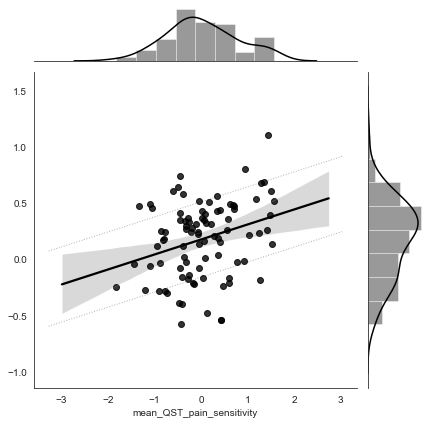

In [10]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions and the models

In [11]:
# save nested L2SO predictions
np.savetxt("../res/multi-center/nested_cv_pred_L1SO.csv", predicted, delimiter=",")

In [12]:
# szeged -> bochum + essen
joblib.dump(all_models[0], '../res/multi-center/model_trained_on_szeged.joblib')

# essen -> bochum + szeged
joblib.dump(all_models[1], '../res/multi-center/model_trained_on_essen.joblib')

# bochum -> essen + szeged
joblib.dump(all_models[2], '../res/multi-center/model_trained_on_bochum.joblib') # RPN-signature

['../res/multi-center/model_trained_on_bochum.joblib']

## Nested leave-one-study-out cross validation (L1SO)
I.e. training on one center only

In [13]:
model, p_grid = pipe_scale_fsel_elnet() # same as before
# Leave-one-study-out

outer_cv = LeavePGroupsOut(1) # LeaveOneStudyOut
inner_cv = LeaveOneOut() # LeaveOneOut, to maximize training samplke                                    
clf = GridSearchCV(estimator=model, param_grid=p_grid, cv=inner_cv,
                   scoring="neg_mean_squared_error", verbose=True, return_train_score=False,
                   n_jobs=-1)

all_models = []
best_params = []
predicted = np.zeros(len(y))
nested_scores_train = np.zeros(outer_cv.get_n_splits(X, groups=df.study))
nested_scores_test = np.zeros(outer_cv.get_n_splits(X, groups=df.study))   
                                    
print("model\tinner_cv mean score\touter vc score")
i=0
for train, test in outer_cv.split(X, y, groups=df.study):                               
    clf.fit(X[train], y[train])
                                    
    print('cv:', i, str(clf.best_params_) + " " + str(clf.best_score_) + " " + str(clf.score(X[test], y[test])))
                                    
    all_models.append(clf.best_estimator_)
    best_params.append(clf.best_params_)
    
    predicted[test] = clf.predict(X[test])
                                    
    nested_scores_train[i] = clf.best_score_
    nested_scores_test[i] = clf.score(X[test], y[test])
    i = i+1


model	inner_cv mean score	outer vc score
Fitting 56 folds for each of 200 candidates, totalling 11200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   13.4s
[Parallel(n_jobs=-1)]: Done 5408 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 6896 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 7449 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done 8099 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 8849 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 9699 tasks      | elapsed: 24.1min
[Parallel(n_jobs=-1)]: Done 10649 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 11200 out of 11200 | elapsed: 32.8min finished


cv: 0 {'fsel__k': 3000, 'model__alpha': 0.001, 'model__l1_ratio': 0.0001} -0.4786247408639663 -0.46313506862736803
Fitting 54 folds for each of 200 candidates, totalling 10800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 160 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1360 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 3360 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 5340 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 6697 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 7253 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 7903 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 8653 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 9503 tasks      | elapsed: 23.5min
[Parallel(n_jobs=-1)]: Done 10453 tasks      | elapsed: 26.8min
[Parallel(n_jobs=-1)]: Done 10800 out of 10800 | elapsed: 27.4min finished


cv: 1 {'fsel__k': 25, 'model__alpha': 0.1, 'model__l1_ratio': 0.75} -0.36603854070891245 -0.9201230210083585
Fitting 72 folds for each of 200 candidates, totalling 14400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 1024 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done 2524 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 4624 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 7324 tasks      | elapsed:   35.7s
[Parallel(n_jobs=-1)]: Done 9067 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 9717 tasks      | elapsed:  6.3min
[Parallel(n_jobs=-1)]: Done 10467 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 11317 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 12267 tasks      | elapsed: 22.9min
[Parallel(n_jobs=-1)]: Done 13317 tasks      | elapsed: 34.7min


cv: 2 {'fsel__k': 25, 'model__alpha': 0.001, 'model__l1_ratio': 0.9999} -0.4992992103253289 -0.35642645741978646


[Parallel(n_jobs=-1)]: Done 14400 out of 14400 | elapsed: 36.7min finished


### Print out the unbiased, nested estimates and plot the (unbiased) nested-cv predictions

*** Score on mean as model:	-0.5655535039999882
** Mean score in the inner crossvaludation (inner_cv):	-0.4479874972994025
** Mean Nested Crossvalidation Score (outer_cv):	-0.5798948490185043
Explained Variance: -0.025358069425941432
Correlation: 0.11446891564173561


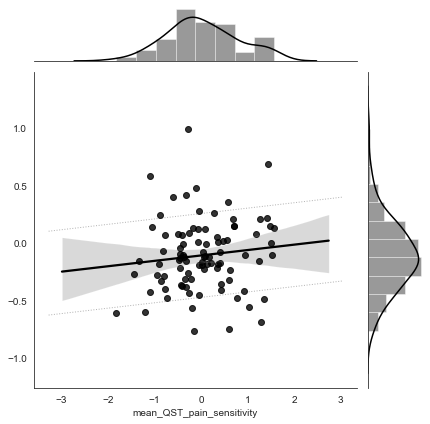

In [14]:
print("*** Score on mean as model:\t" + str(-mean_squared_error(np.repeat(y.mean(), len(y)), y)))
print("** Mean score in the inner crossvaludation (inner_cv):\t" + str(nested_scores_train.mean()))
print("** Mean Nested Crossvalidation Score (outer_cv):\t" + str(nested_scores_test.mean()))
print("Explained Variance: " +  str( 1- nested_scores_test.mean()/-mean_squared_error(np.repeat(y.mean(), len(y)), y) ))
print("Correlation: " + str(np.corrcoef(y, predicted)[0,1]))
                                    
plot.plot_prediction(y, predicted, sd=True, covar=[])

### Save the nested-cv predictions and the models

In [15]:
# save nested L2SO predictions
np.savetxt("../res/multi-center/nested_cv_pred_L2SO.csv", predicted, delimiter=",")

In [16]:
# essen+szeged -> bochum
joblib.dump(all_models[0], '../res/multi-center/model_trained_on_essen+szeged.joblib')

# bochum+szeged -> essen
joblib.dump(all_models[1], '../res/multi-center/model_trained_on_bochum+szeged.joblib')

# bochum+essen -> szeged
joblib.dump(all_models[2], '../res/multi-center/model_trained_on_bochum+essen.joblib')

['../res/multi-center/model_trained_on_bochum+essen.joblib']

## Analyze L2SO

In [17]:
#L2SO
predicted_l2so = np.genfromtxt("../res/multi-center/nested_cv_pred_L1SO.csv", delimiter=",")

Explained Variance:  0.15949843986635404
Correlation:  0.40800152074998414
p = 0.00075


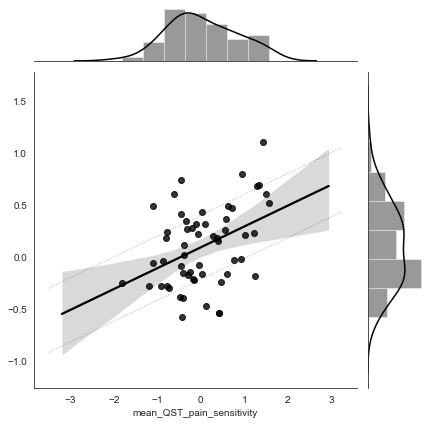

In [18]:
from mlxtend.evaluate import permutation_test
y_true = y[df.study!='bochum']
y_hat = predicted_l2so[df.study!='bochum']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  0.06871920657208275
Correlation:  0.2872129172133841
p = 0.01825


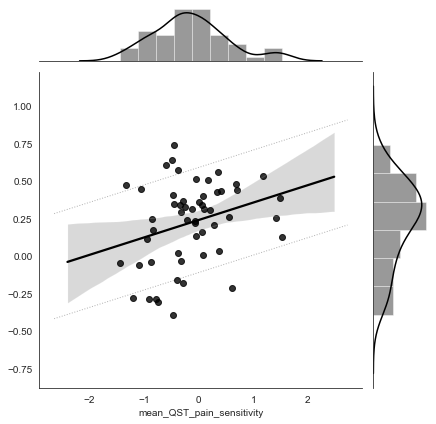

In [19]:
y_true = y[df.study!='essen']
y_hat = predicted_l2so[df.study!='essen']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  0.021387967824524345
Correlation:  0.242238703389592
p = 0.0205


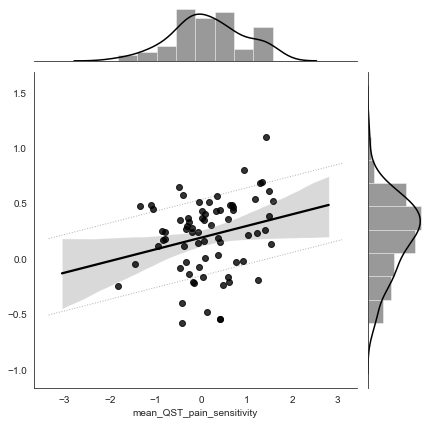

In [20]:
y_true = y[df.study!='szeged']
y_hat = predicted_l2so[df.study!='szeged']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

In [21]:
p_corr = permutation_test(y, predicted_l2so,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                

p = 0.0015


## Analyze L1SO


In [22]:
#L1SO
predicted_l1so = np.genfromtxt("../res/multi-center/nested_cv_pred_L2SO.csv", delimiter=",") # typo in name

Explained Variance:  0.12457509068586337
Correlation:  0.37790787358073125
p = 0.014625


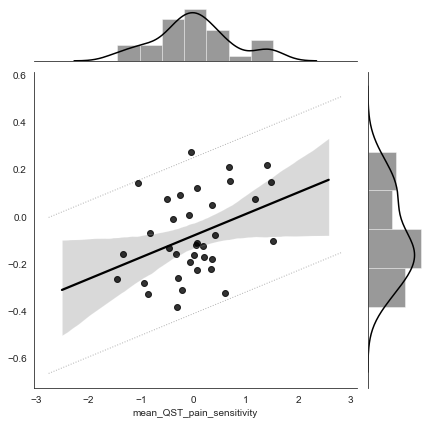

In [23]:
from mlxtend.evaluate import permutation_test
y_true = y[df.study=='bochum']
y_hat = predicted_l1so[df.study=='bochum']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  -0.13410888748110494
Correlation:  0.0733541907402749
p = 0.33175


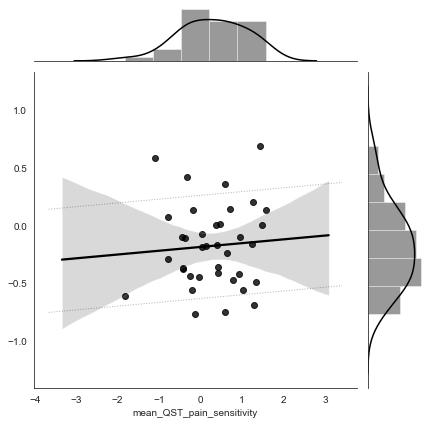

In [24]:
y_true = y[df.study=='essen']
y_hat = predicted_l1so[df.study=='essen']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])

Explained Variance:  0.07852892889856766
Correlation:  0.46770669440476986
p = 0.019875


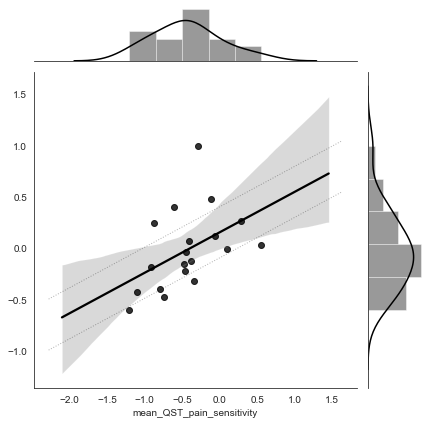

In [25]:
y_true = y[df.study=='szeged']
y_hat = predicted_l1so[df.study=='szeged']


print("Explained Variance: ",  explained_variance_score(y_true, y_hat))
print("Correlation: ", str(np.corrcoef(y_true, y_hat)[0,1]))

p_corr = permutation_test(y_true, y_hat,
                           func=lambda x, y: np.corrcoef(x, y)[0,1],
                           method='approximate',
                           num_rounds=8000,
                           seed=42)
print('p =', p_corr)
                                    
plot.plot_prediction(y_true, y_hat, sd=True, covar=[])